**Let us import the libraries and explore the data.**

In [69]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedShuffleSplit,cross_val_score


In [70]:
df=pd.read_csv('exercise.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 11 columns):
Feature_0    1410 non-null float64
Feature_1    1421 non-null float64
Feature_2    1415 non-null float64
Feature_3    1421 non-null float64
Feature_4    1418 non-null float64
Feature_5    1406 non-null float64
Feature_6    1418 non-null float64
Feature_7    1410 non-null float64
Feature_8    1419 non-null float64
Feature_9    1415 non-null float64
Class        1429 non-null int64
dtypes: float64(10), int64(1)
memory usage: 122.9 KB


**It seems that all features are floats, and that some data is missing. 
Let us check:**

In [71]:
print("About {:.2f}% of measures contain missing values,".format((len(df)-len(df.dropna()))/len(df)*100))
print('and {:.2f}% of them have more than 1 missing value.'.format((len(df)-len(df.dropna(thresh=2)))/len(df)*100))

About 9.45% of measures contain missing values,
and 0.00% of them have more than 1 missing value.


**Let us find out more about the features before we decide if we drop them or if we fill them, which method to use:**

In [72]:
df.describe()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
count,1410.000000,1421.000000,1415.000000,1421.000000,1418.000000,1406.000000,1418.000000,1410.000000,1419.000000,1415.000000,1429.000000
mean,2.761278,18.836509,-9.570223,9.982570,13.792544,-18.587160,-16.879084,-22.516671,-0.934358,9.958484,0.375787
std,0.092740,0.063372,0.226868,0.248747,1.538595,0.510192,9.431922,0.027776,0.326741,0.427736,0.484495
min,2.140701,18.043017,-10.471220,9.148813,9.178957,-21.330718,-45.823666,-23.147576,-2.135276,8.928247,0.000000
25%,2.741825,18.841566,-9.690766,9.865447,12.810516,-18.803854,-23.464018,-22.515233,-1.106257,9.669022,0.000000
50%,2.810525,18.841566,-9.612721,10.008774,13.687099,-18.432257,-16.835631,-22.515233,-0.890881,9.926164,0.000000
75%,2.810525,18.841566,-9.495653,10.152101,14.688909,-18.246458,-10.522323,-22.515233,-0.699436,10.197245,1.000000
max,2.999449,18.841566,-7.622564,11.413376,20.073634,-17.614742,12.196056,-22.515233,-0.005447,11.643751,1.000000


**From their basic statistical indicators, we suspect now that Features 1 and 7 are most likely constants, at least for values above the 25th percentile. Those of the of target variable "Class" simply tell us that on this set of measures, ~62.5% of them are "negative", or 0. We can keep it in mind as a base for accuracy as a model predicting all "negatives would be right 62.5% of the time. 
Let's investigate a little deeper the distributions and their correlations. Doing a pairplot will give us early indicatiors on possible dimension reduction, outliers and leakage.**

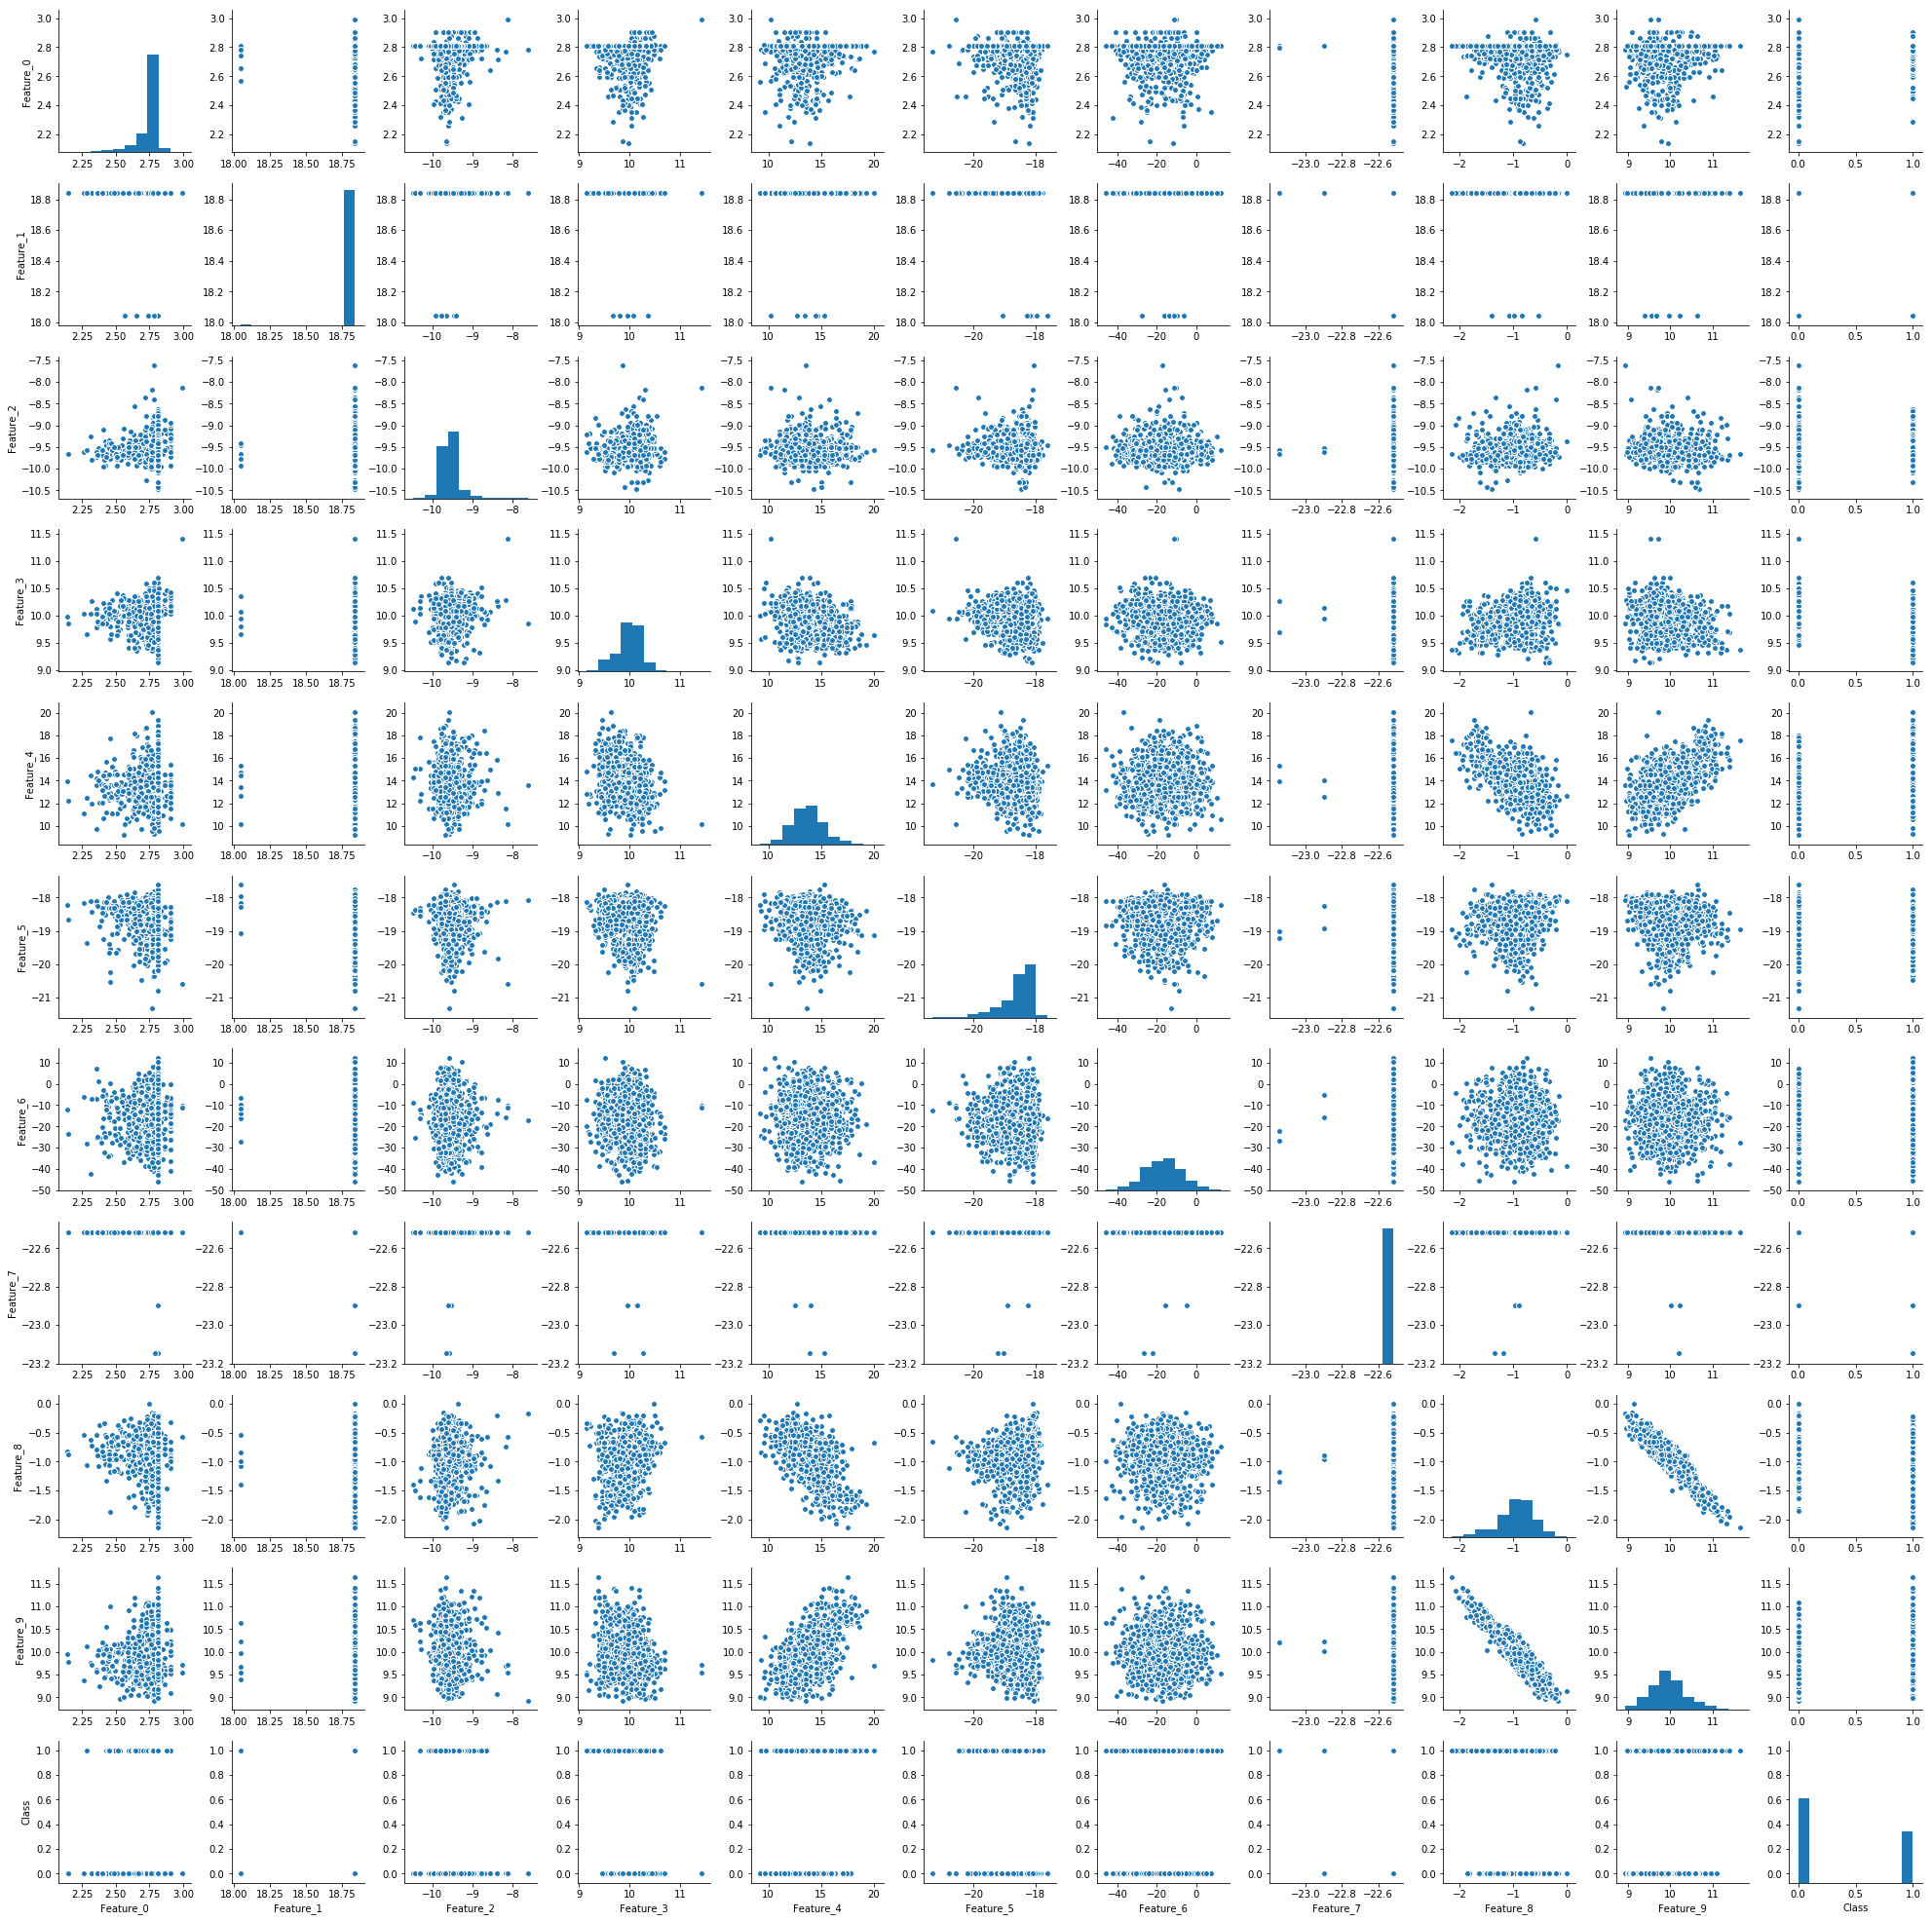

In [73]:
sns.pairplot(df.iloc[:,:11].dropna());

**We see that the outliers of our constant features (1 & 7) are not directly correlated with the target variable. We also recognize some redundant features (heavily correlated) in Features 8 & 9. Let's confirm with a heatmap of the feature's correlations, in absolute value:**

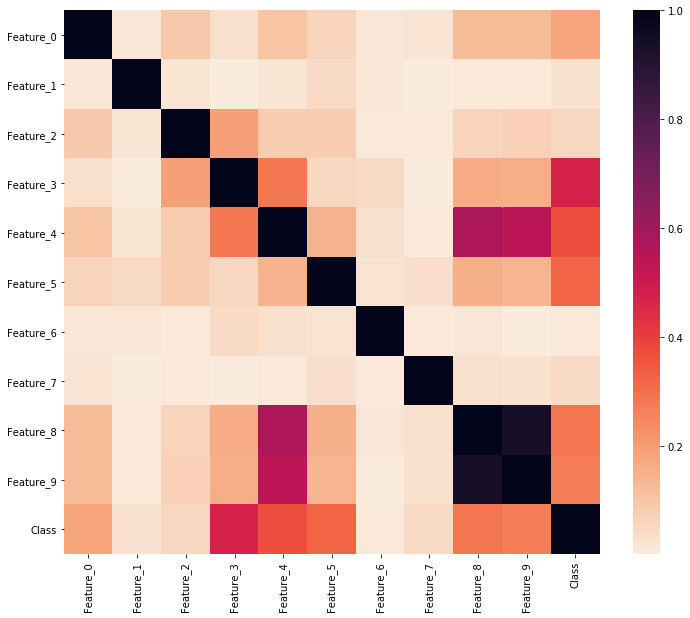

In [74]:
plt.figure(figsize=(12,10))
sns.heatmap(abs(df.corr()),cmap='rocket_r');

**Let us now check how many outliers we have on Feature 1 & 7:**

In [75]:
print(df.groupby('Feature_1').Feature_0.count())
print(df.groupby('Feature_7').Feature_0.count())

Feature_1
18.043017       9
18.841566    1393
Name: Feature_0, dtype: int64
Feature_7
-23.147576       2
-22.896163       2
-22.515233    1387
Name: Feature_0, dtype: int64


**These do not look like outliers, they may contain valuable information. Let us now do a simple Logistic Regression with the missing values dropped.**

In [76]:
data=df.dropna()
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.2)
model=LogisticRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

print('Here is the confusion matrix of the prediction:')
print(confusion_matrix(y_test,y_pred))
print('\n Here is the classification report:')
print(classification_report(y_test,y_pred))
print("A mean ROC_AUC on 10 randomly guessed predictions is: {}".format(np.mean([roc_auc_score(y_test,np.random.randint(2,size=len(y_test)))for i in range(10)])))
print("The ROC_AUC of our model is: {}".format(roc_auc_score(y_test,y_pred)))

Here is the confusion matrix of the prediction:
[[155   8]
 [ 40  56]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       0.79      0.95      0.87       163
          1       0.88      0.58      0.70        96

avg / total       0.82      0.81      0.80       259

A mean ROC_AUC on 10 randomly guessed predictions is: 0.49206607873210634
The ROC_AUC of our model is: 0.7671267893660532


**Let's now impute the missing values using the median, as it seems that the distributions are either quite symmetric or concentrated in a single value, hence taking place of 'mean' and 'most_frequent' respectively, scale and run a cross validation on a stratified split to see how it improves the score:**

In [78]:
#X=Imputer(missing_values=np.nan, strategy='median', axis=0).fit_transform(df.iloc[:,:-1])
#y=df.iloc[:,-1]
#X_norm=StandardScaler().fit_transform(X)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

pipe=Pipeline([("imputer", Imputer(missing_values=np.nan,
                                          strategy="median",
                                          axis=0)),
               ('scaler',StandardScaler()),
               ("logreg", LogisticRegression())]
             )

print("A mean ROC_AUC on 10 randomly guessed predictions is: {}".format(np.mean([roc_auc_score(y_test,np.random.randint(2,size=len(y_test)))for i in range(10)])))
print('Our cross validation has a mean ROC_AUC of : {}'.format(np.mean(cross_val_score(pipe,df.iloc[:,:-1],df.iloc[:,-1],cv=sss,scoring='roc_auc'))))

A mean ROC_AUC on 10 randomly guessed predictions is: 0.49764506646216766
Our cross validation has a mean ROC_AUC of : 0.871309977549209


**We note that the score hasvastly improved, which shouldn't be a surprise as we had previously dropped a significant amount of the data and hadn't rescaled the features. Note that a principal component analysis is unnecessary as the number of variables is low. Testing it shows that the best scores are obtained with a feature dimension of 9, which is logical as we saw that two features were extremely correlated.**